In [1]:
import os, math
import pandas as pd
import numpy as np
import random, io

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def load_all_csv():
    train_name = os.path.join("data", "HW2_hr-analytics_train.csv")
    test_name = os.path.join("data", "HW2_hr-analytics_test.csv")
    train_df = pd.read_csv(train_name)
    test_df = pd.read_csv(test_name)
    return train_df, test_df

def shuffle(x_chunk, y_chunk):
    buf = list()
    for x, y in zip(x_chunk, y_chunk):
       buf.append((x,y))
    random.shuffle(buf)

    x_chunk_out, y_chunk_out = list(), list()
    for x, y in buf:
        x_chunk_out.append(x)
        y_chunk_out.append(y)
    x_chunk_out = np.array(x_chunk_out, dtype=np.float32)
    y_chunk_out = np.array(y_chunk_out, dtype=np.int32)
    return x_chunk_out, y_chunk_out

def split(x_chunk, y_chunk, r=0.9):
    x_chunk, y_chunk = shuffle(x_chunk, y_chunk)
    size = round(len(y_chunk) * r) 
    train_x = x_chunk[:size]
    train_y = y_chunk[:size]
    test_x = x_chunk[size:]
    test_y = y_chunk[size:]
    return train_x, train_y, test_x, test_y 

def test_performance(lr, test_x, test_y):
    pred = lr.predict(test_x)

    cnt, cor = 0, 0
    for p, r in zip(pred, test_y):
        cnt += 1
        if p == r:
            cor += 1
    # print(cor/cnt)
    table = confusion_matrix(test_y, pred)

    plt.figure(figsize=(7,4))
    sns.heatmap(table,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel("Pred",fontsize=20)
    plt.ylabel("True",fontsize=20)
    plt.show()

    Y = table[0][0]/(table[0][0] + table[0][1]) + table[1][1]/(table[1][0] + table[1][1]) - 1
    print("Youden Index : {:.4f}".format(Y))

def print_results(lr, x_chunk):
    pred_result = "left\n"
    pred = lr.predict(x_chunk)

    for p in pred:
        pred_result += "{}\n".format(p)
    pred_result = pred_result[:-1]
    df = pd.read_csv(io.StringIO(pred_result), sep=",", header=None)
    print(df)

def get_data_format(df):
    dformat = dict()
    for label in df.keys().values:
        dformat[label] = dict()
    for k, v in df.dtypes.items():
        dformat[k]["obj"] = v == object
    for k, v in df.max(axis=0).items():
        if not dformat[k]["obj"]:
            dformat[k]["max"] = v
    for label in df.keys().values:
        if dformat[label]["obj"]:
            tset = set()
            vmape = dict()
            for v in df[label].values:
                tset.add(v)
            tset = sorted(list(tset))
            for i, v in enumerate(tset):
                vmape[v] = i
            dformat[label]["map"] = vmape
            dformat[label]["size"] = len(tset)
    return dformat

def transfer_data(df, dformat):
    labels = df.keys().values
    x_chunk = list()
    y_chunk = list()
    for index, row in df.iterrows():
        x = list()
        y = int(0)

        for label in labels:
            val = row[label]
            fmt = dformat[label]
            if label == "left":
                y = val
            else:
                if fmt["obj"]:
                    sub = [0] * fmt["size"]
                    sub[fmt["map"][val]] = 1
                else:
                    sub = [ val/fmt["max"]  ]
                x.extend(sub)
        x_chunk.append(x)
        y_chunk.append(y)
    x_chunk = np.array(x_chunk, dtype=np.float32)
    y_chunk = np.array(y_chunk, dtype=np.int32)
    return x_chunk, y_chunk

### Step 1
預先載入所有資料，並解析資料要使用的格式

In [2]:
train_df, test_df = load_all_csv()
dformat = get_data_format(train_df)
x_chunk, y_chunk = transfer_data(train_df, dformat)

### Step 2
建構並訓練模型

In [3]:
train_x, train_y, test_x, test_y = split(x_chunk, y_chunk, r=0.9)
lr = LogisticRegression()
lr.fit(train_x, train_y)

LogisticRegression()

### Step 3
列印混淆矩陣和約登指數

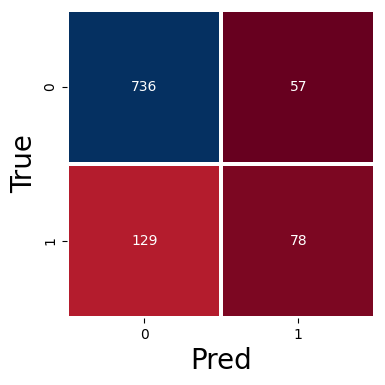

Youden Index : 0.3049


In [4]:
test_performance(lr, test_x, test_y)

### Step 4
預測結果

In [5]:
x_chunk, _ = transfer_data(test_df, dformat)
print_results(lr, x_chunk)

         0
0     left
1        0
2        0
3        1
4        1
...    ...
4996     0
4997     0
4998     1
4999     0
5000     0

[5001 rows x 1 columns]
